In [1]:
import sys
sys.path.append('../../..')
import numpy as np
from tqdm import tqdm_notebook as tqdm
from scipy.interpolate import interp1d, interp2d

import config
import main
import pickle
import darkhistory.physics as phys
from darkhistory.spec.spectra import Spectra
from darkhistory.spec.spectrum import Spectrum
import darkhistory.low_energy.atomic as atomic
import darkhistory.spec.spectools as spectools
# from plotting_utils import plot_distortion, download_plot

import matplotlib
matplotlib.rc_file('../../../matplotlibrc')
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as colors
%matplotlib inline

In [39]:
### SETTINGS TO CHANGE
output_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/output/'
fig_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/figs/'

# Choose to load data (True) or start a new scan (False)
load_data = False

# Scan over parameters, or load previous data

In [3]:
# CMB constraints on interaction rates
input_dir = config.data_path

f_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_swave.dat', delimiter=',')
log10eng_elec_CMB  = f_elec_CMB_raw[0:2760:69, 0]
log10rs_elec_CMB = f_elec_CMB_raw[0:69, 1]

f_phot_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_phot_swave.dat', delimiter=',')
log10eng_phot_CMB  = f_phot_CMB_raw[0:2800:70, 0]
log10rs_phot_CMB = f_phot_CMB_raw[0:70, 1]

f_elec_CMB_raw = np.transpose(np.reshape(f_elec_CMB_raw[:,2], (40,69)))
f_phot_CMB_raw = np.transpose(np.reshape(f_phot_CMB_raw[:,2], (40,70)))

f_elec_CMB = interp2d(log10eng_elec_CMB, log10rs_elec_CMB, f_elec_CMB_raw)
f_phot_CMB = interp2d(log10eng_phot_CMB, log10rs_phot_CMB, f_phot_CMB_raw)

decay_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_phot_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_phot_decay.csv', delimiter=',')

decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])
decay_phot_CMB = interp1d(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:])

#Derived from Planck 2018 cosmological parameters
p_ann = 3.5e-28

def param_bound_elec_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_elec_CMB(np.log10(mDM-phys.me), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_elec_CMB(mDM*1e-9)])[0]

def param_bound_phot_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_phot_CMB(mDM*1e-9)])[0]
    
def param_bound(mDM, DM_process, pri):
    if pri == 'elec':
        return param_bound_elec_CMB(mDM, DM_process)
    else:
        return param_bound_phot_CMB(mDM, DM_process)

In [44]:
### Parameters
start_rs, high_rs, end_rs = 3e3, 1.555e3, 4
cf = 16
rtol = 1e-6
nmax = 10 # maximum number of hydrogen levels to track
iter_max = 5 # number of times to iterate over recombination/ionization rates

log10eng0 = 3.6989700794219966
log10eng = np.array([log10eng0 + 0.23252559*i for i in np.arange(40)])
log10eng[-1] = 12.601505994846297

models = ['elec_decay', 'elec_swave', 'phot_decay', 'phot_swave']

In [46]:
if load_data == True:
    data = pickle.load(open(output_dir+f'scans_nmax{nmax}.dat','rb'))
else:
    # Scan over models and mass ranges
    data = {}

    # We use the iterative method.
    # First solve the evolution equations assuming Recfast's
    # alpha_B and beta_B rates (e.g. by setting recfast_TLA = True).
    # One output is the a new, more accurate set of rates
    # These rates can then be plugged back into the MLA equations
    # Continued iteration leads to more accurate rates
    # but this process converges quickly (after one iteration)
    for iteration in range(iter_max):
        print('~~~Iteration ', iteration, '~~~')
        data[iteration] = {model : [] for model in models}
        for pri in ['elec', 'phot']:
            for DM_process in ['decay', 'swave']:
                model = pri+'_'+DM_process
                print('starting', model)

                if pri=='elec':
                    if DM_process=='decay':
                        mDM_list = 2*(10**log10eng + phys.me)
                    else:
                        mDM_list = 10**log10eng + phys.me
                elif pri=='phot':
                    if DM_process=='decay':
                        mDM_list = 2*10**log10eng
                    else:
                        mDM_list = 10**log10eng

                for mi, mDM in enumerate(tqdm(mDM_list)):     
                    param = param_bound(mDM, DM_process, pri)

                    # If this is first iteration, use Recfast TLA rates
                    if iteration == 0:
                        TLA_switch = True
                        MLA_funcs = None
                    # For subsequent iterations, use rates calculated from previous run
                    else:
                        TLA_switch = False
                        rates = data[iteration-1][model][mi]['MLA']
                        MLA_funcs = [interp1d(rates[0], rates[i], fill_value='extrapolate')
                            for i in range(1,4)]

                    goods = main.evolve(
                        DM_process=DM_process, mDM=mDM,
                        lifetime=param, sigmav = param,
                        primary=pri+'_delta',
                        start_rs = start_rs, high_rs = high_rs, end_rs=end_rs,
                        reion_switch=True, reion_method='Puchwein', heat_switch=True,
                        coarsen_factor=cf,
                        distort=True, recfast_TLA=TLA_switch, MLA_funcs=MLA_funcs,
                        fexc_switch = True, reprocess_distortion=True, 
                        nmax=nmax, rtol=rtol
                    )
                    
                    # Add the data for this iteration, model, and mass point
                    data[iteration][model].append(goods)
                    pickle.dump(data, open(output_dir+f'scans_nmax{nmax}.dat','wb'))

~~~Iteration  0 ~~~
starting elec_decay


starting elec_swave


starting phot_decay


starting phot_swave


~~~Iteration  1 ~~~
starting elec_decay


starting elec_swave


starting phot_decay


starting phot_swave


~~~Iteration  2 ~~~
starting elec_decay


KeyboardInterrupt: 

# Plot all distortions

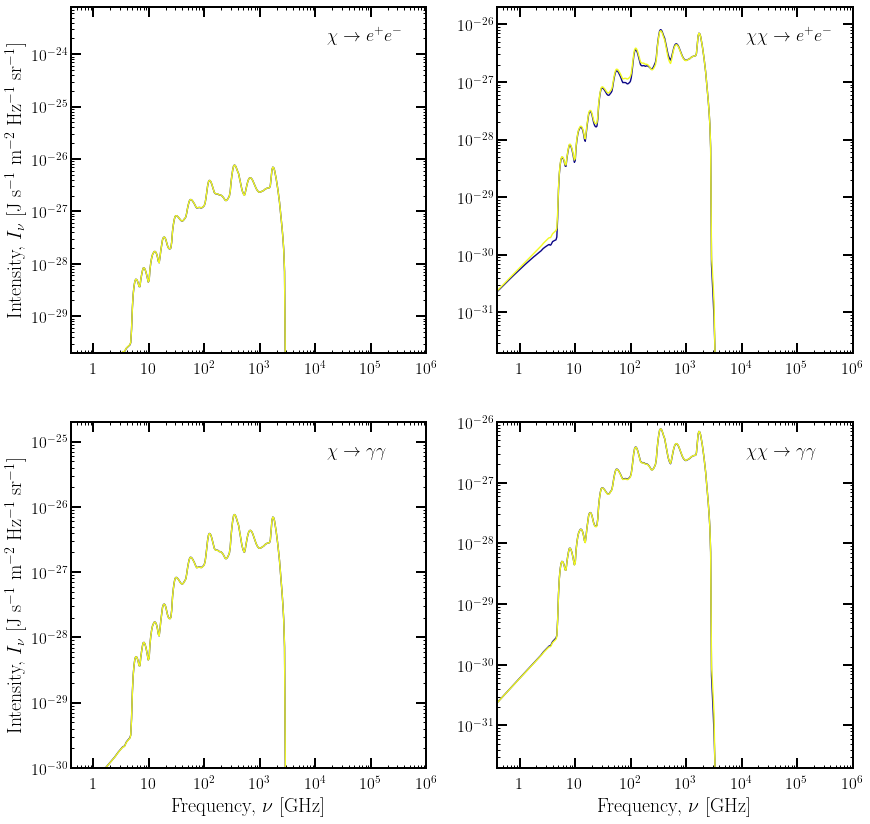

In [61]:
eng = data[0]['elec_decay'][0]['distortion'].eng
hplanck = phys.hbar * 2 * np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck

fig, axarr = plt.subplots(2,2, figsize=(14, 14))
cmap = cm.plasma(np.linspace(0.,1.,len(data[0]['elec_decay'])))

for i, pri in enumerate(['elec', 'phot']):
    axarr[i][0].set_ylabel(r'Intensity, $I_{\nu}$ '+
                           '[J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)
    for j, DM_process in enumerate(['decay', 'swave']):
        axarr[i][j].loglog()
        axarr[i][j].set_xlim([4e-1, 1e6])
        if i==1:
            axarr[i][j].set_xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
        
        if DM_process == 'swave':
            if pri == 'elec':
                axarr[i][j].set_ylim([2e-32, 2e-26])
                axarr[i][j].text(0.7, 0.9, r'$\chi\chi \rightarrow e^+ e^-$', 
                                 fontsize = 18, transform = axarr[i][j].transAxes)
            else:
                axarr[i][j].set_ylim([2e-32, 1e-26])
                axarr[i][j].text(0.7, 0.9, r'$\chi\chi \rightarrow \gamma\gamma$', 
                                 fontsize = 18, transform = axarr[i][j].transAxes)
        else:
            if pri == 'elec':
                axarr[i][j].set_ylim([2e-30, 8e-24])
                axarr[i][j].text(0.72, 0.9, r'$\chi \rightarrow e^+ e^-$', 
                                 fontsize = 18, transform = axarr[i][j].transAxes)
            else:
                axarr[i][j].set_ylim([1e-30, 2e-25])
                axarr[i][j].text(0.72, 0.9, r'$\chi \rightarrow \gamma\gamma$', 
                                 fontsize = 18, transform = axarr[i][j].transAxes)
        
        model = pri+'_'+DM_process
        
        for k in range(len(data[0][model])):
            axarr[i][j].plot(nu/1e9, convert * data[iter_max-1][model][k]['distortion'].dNdE,
                            color=cmap[k], linestyle='solid', linewidth=1.4)
            axarr[i][j].plot(nu/1e9, -convert * data[iter_max-1][model][k]['distortion'].dNdE,
                            color=cmap[k], linestyle='--', linewidth=1.4)
#         axarr[i][j].plot(BB_BF_jens[:,0], BB_BF_jens[:,1], color='k', linestyle='--',
#                  linewidth=2.0, label='Chluba+Sunyaev', alpha=0.6)
plt.savefig(fig_dir+'distortion_grid.pdf')
plt.show()

# Show convergence with each iteration

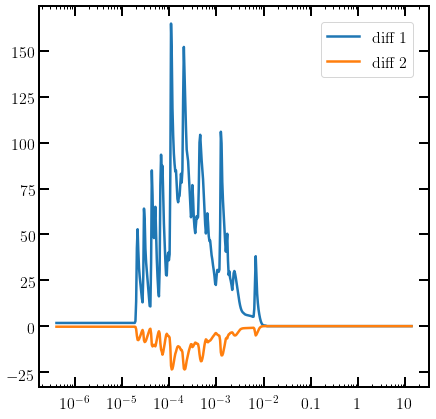

In [37]:
plt.figure(figsize=(7,7))
# plt.loglog()
plt.xscale('log')
# plt.plot(data[0]['elec_decay']['distortion'].eng, data[0]['elec_decay']['distortion'].dNdE, label='iter 0')
# plt.plot(data[1]['elec_decay']['distortion'].eng, data[1]['elec_decay']['distortion'].dNdE, 'r--', label='iter 1')
# plt.plot(data[2]['elec_decay']['distortion'].eng, data[2]['elec_decay']['distortion'].dNdE, label='iter 2')
plt.plot(data[1]['elec_decay']['distortion'].eng, data[1]['elec_decay']['distortion'].dNdE - data[0]['elec_decay']['distortion'].dNdE,
         label='diff 1')
plt.plot(data[2]['elec_decay']['distortion'].eng, data[2]['elec_decay']['distortion'].dNdE - data[1]['elec_decay']['distortion'].dNdE,
         label='diff 2')
# plt.ylim(10,1e4)
plt.legend()
plt.show()